# Exercise 1 on Clustering and Local PCA

The goal of the exercise is to perform perform clustering on a dataset representing a noisy 2D non-linear function.
* How do we select the correct number of clusters?
* Why LPCA works better than PCA on a non-linear dataset?

First thing, we create our synthetic dataset

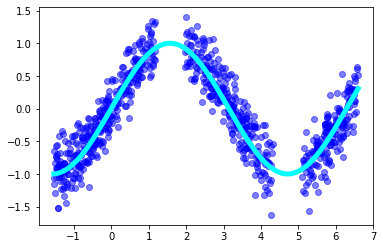

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

def non_linear_func_orig(x):
    y = np.sin(x)
    return y

def non_linear_func(x):
    y = np.sin(x) + 0.25*np.random.randn(x.size) 
    return y
    
# This code is used to create our synthetic dataset
size = 1000
seed = 42
np.random.seed(seed)

x = np.random.rand(size) * 2.6*np.pi - np.pi/2
y = non_linear_func(x)

limits = [np.pi/2, 3/2*np.pi]
eps = np.pi/8

mask = ((x < limits[0] + eps) & (x > limits[0] - eps)) | (x < limits[1] + eps) & (x > limits[1] - eps)
x = x[~mask]
y = y[~mask]

X = np.zeros((x.size, 2))
X[:,0] = x
X[:,1] = y

x_orig = np.linspace(x.min(), x.max(), 200)
y_orig = np.sin(x_orig)

# We can plot the dataset and the original non-linear function
plt.scatter(X[:,0], X[:,1], c='b', alpha=0.5)
plt.plot(x_orig, y_orig, c='cyan', lw=5)
plt.show()


## Global PCA
Now we apply the PCA and try to reconstruct the dataset using only one dimension.

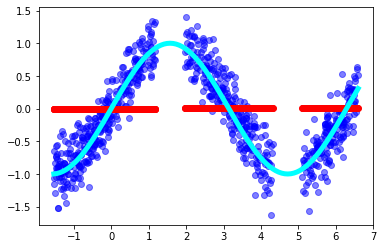

In [2]:
# We import the PCA object from the sklearn package
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

A = pca.components_.T
Z = X @ A

q = 1 # we select only one PC
X_rec = Z[:,:q] @ A[:,:q].T

plt.scatter(X[:,0], X[:,1], c='b', alpha=0.5)
plt.plot(x_orig, y_orig, c='cyan', lw=5)
plt.scatter(X_rec[:,0], X_rec[:,1], c='red')
plt.show()


## Clustering

We can try and improve the reconstruction accuracy using a local approach. The first thing to do is then to cluster the dataset using kmeans.

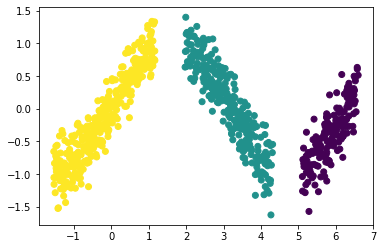

In [3]:
# We import the KMEANS object from the sklearn package
from sklearn.cluster import KMeans
k = 3
kmeans = KMeans(n_clusters=k, init='random')
kmeans.fit(X)
labels = kmeans.labels_

# We plot the data coloured by cluster label
plt.scatter(X[:,0], X[:,1], c=labels)
plt.show()


## Selection of the clusters' number

In this case we can visually identify the number of clusters, because we have only two dimensions. In higher dimensions, it is not possible to visualize the dataset. Also, we would prefer to have an automatic method to select the correct number of clusters.

We can use the Devies Bouldin score to estimate the number of clusters.


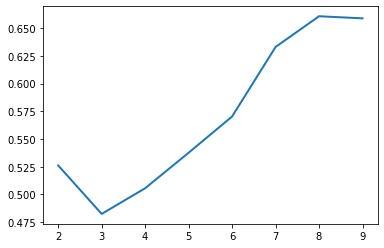

In [4]:
from sklearn.metrics import davies_bouldin_score

# We compute the DB score for different number of clusters k and we look for the minimum.
k_array = np.arange(2,10)
db_score_array = np.zeros((k_array.size,)) 

for i, k in enumerate(k_array):
    kmeans = KMeans(n_clusters=k, init='random')
    kmeans.fit(X)
    labels = kmeans.labels_
    db_score = davies_bouldin_score(X, labels)
    db_score_array[i] = db_score

n_clusters = k_array[np.argmin(db_score_array)]

plt.plot(k_array, db_score_array, lw=2)
plt.show()


## Local PCA

Now we can apply the PCA in each cluster.

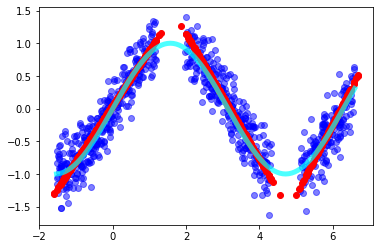

In [5]:
# first we compute Kmeans to find the labels with the correct number of clusters
kmeans = KMeans(n_clusters=n_clusters, init='random')
kmeans.fit(X)
labels = kmeans.labels_

pca = PCA()

# the for cycle is used to fit the PCA model in each cluster
for k in range(n_clusters):
    mask = (labels == k)
    X_k = X[mask] # the mask is used to select the clusters with a specific label
    Xc_k = X_k - np.mean(X_k, axis=0) # we need to center the data in each cluster
    pca.fit(Xc_k)
    A_k = pca.components_.T
    Z_k = Xc_k @ A_k
    X_k_rec = Z_k[:,:q] @ A_k[:,:q].T + np.mean(X_k, axis=0)
    plt.scatter(X_k[:,0], X_k[:,1], c='b', alpha=0.5)
    plt.scatter(X_k_rec[:,0], X_k_rec[:,1], c='r')

plt.plot(x_orig, y_orig, c='cyan', lw=5, alpha=0.7)
plt.show()

## Local PCA with VQPCA

We can compare the KMEANS results with VQPCA. To perform VQPCA, we need the [OpenMORe](https://github.com/burn-research/OpenMORe) library. You can find the instruction for the installation in the README document. 

In [6]:
import OpenMORe.clustering as clustering

# This is a dictionary used to set the VQPCA parameters.
settings_clustering = {
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #set the initialization method (random, observations, kmeans, pkcia, uniform)
    "initialization_method"     : "random",

    #set the number of clusters and PCs in each cluster
    "number_of_clusters"        : 3,
    "number_of_eigenvectors"    : 1,

    #enable additional options:
    "correction_factor"         : "off",    # --> enable eventual corrective coefficients for the LPCA algorithm:
                                            #     'off', 'c_range', 'uncorrelation', 'local_variance', 'phc_multi', 'local_skewness' are available

    "classify"                  : False,    # --> call the method to classify a new matrix Y on the basis of the lpca clustering
    "write_on_txt"              : False,    # --> write the idx vector containing the label for each observation
    "evaluate_clustering"       : True,     # --> enable the calculation of indeces to evaluate the goodness of the clustering
    "neighbors_number"          : 0,
}

# First we create the model and then we fit it to the dataset
model = clustering.lpca(X, settings_clustering)
labels_vqpca = model.fit()


Preprocessing training matrix..
Fitting Local PCA model...
- Iteration number: 1
	Reconstruction error: 0.4126640989591744
	Reconstruction error variance: 1.4232784061473007
- Iteration number: 2
	Reconstruction error: 0.123206853925631
	Reconstruction error variance: 2.3493599244751673
- Iteration number: 3
	Reconstruction error: 0.08063829189233662
	Reconstruction error variance: 0.5278951356029383
- Iteration number: 4
	Reconstruction error: 0.06735993828090533
	Reconstruction error variance: 0.1971253826875213
- Iteration number: 5
	Reconstruction error: 0.060456721164308905
	Reconstruction error variance: 0.11418444440337581
- Iteration number: 6
	Reconstruction error: 0.05306950570538561
	Reconstruction error variance: 0.13919887439565168
- Iteration number: 7
	Reconstruction error: 0.04667188476632887
	Reconstruction error variance: 0.13707654985624776
- Iteration number: 8
	Reconstruction error: 0.0407983972987495
	Reconstruction error variance: 0.14396368133214382
- Iteration 

Observation number: 550
Observation number: 551
Observation number: 552
Observation number: 553
Observation number: 554
Observation number: 555
Observation number: 556
Observation number: 557
Observation number: 558
Observation number: 559
Observation number: 560
Observation number: 561
Observation number: 562
Observation number: 563
Observation number: 564
Observation number: 565
Observation number: 566
Observation number: 567
Observation number: 568
Observation number: 569
Observation number: 570
Observation number: 571
Observation number: 572
Observation number: 573
Observation number: 574
Observation number: 575
Observation number: 576
Observation number: 577
Observation number: 578
Observation number: 579
Observation number: 580
Observation number: 581
Observation number: 582
Observation number: 583
Observation number: 584
Observation number: 585
Observation number: 586
Observation number: 587
Observation number: 588
Observation number: 589
Observation number: 590
Observation numb

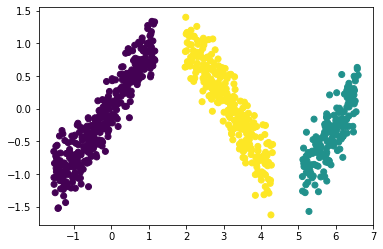

In [7]:
# Now we can plot the clusters
plt.scatter(X[:,0], X[:,1], c=labels_vqpca)
plt.show()
